<a href="https://colab.research.google.com/github/linkwine/machine-learning/blob/master/collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering with Surprise
###The goal of this project is to build up a movie recommender system with Python Scikit Suprise package (http://surpriselib.com/).


![Netflix](https://raw.githubusercontent.com/linkwine/machine-learning/master/netflix.jpg)

Datasource: Kaggle 'Netflix Prize Data'.
https://www.kaggle.com/netflix-inc/netflix-prize-data



# Ingest

### Load library

In [0]:
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt


import math
import re

import time

In [0]:
#install surprise package
!pip install -q scikit-surprise

In [0]:
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, SVD, evaluate

### Import data from Google Drive

In [5]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
drive_service = build('drive', 'v3')

# 2. import csv file from Google Drive
# A file ID looks like: 1uBtlaggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1HhUlucV3tDN9WeTdFKockhamCVF4DkJv'

import io
from googleapiclient.http import MediaIoBaseDownload

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()

downloaded.seek(0)

0

In [5]:
# 3. import txt file from Google Drive
file_id_2 = '1gZuxDt1k84C994Rx6mvBrhtbLGnEqJeM'   # movie rating

request_2 = drive_service.files().get_media(fileId=file_id_2)
downloaded_2 = io.BytesIO()
downloader_2 = MediaIoBaseDownload(downloaded_2, request_2)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader_2.next_chunk()

downloaded_2.seek(0)

0

### View data

In [0]:
# endcode ISO-8859-1 format
df_movie = pd.read_csv(downloaded, header=None,  encoding = "ISO-8859-1", names = ['Movie_Id', 'Year', 'Name'])

In [0]:
df_movie.set_index('Movie_Id', inplace=True)

In [8]:
df_movie.head()

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [9]:
df_movie.count()

Year    17763
Name    17770
dtype: int64

In [10]:
df_movie.isna().sum()

Year    7
Name    0
dtype: int64

In [0]:
df_rating = pd.read_csv(downloaded_2, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


In [10]:
df_rating.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [15]:
df_rating.isna().sum()

Cust_Id       0
Rating     4499
dtype: int64

In [16]:
df_rating.count()

Cust_Id    24058263
Rating     24053764
dtype: int64

# Data Manipulation

### EDA

In [17]:
df_rating.groupby('Rating').count()

,Cust_Id
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


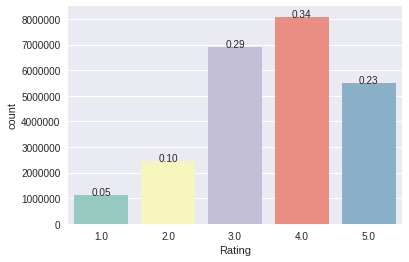

In [18]:
ax = sns.countplot(data=df_rating, x='Rating', palette='Set3')

total = float(len(df_rating)) 

# annotate percentage in the countplot
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

### Reshape Data

In [11]:
df_nan= df_rating[(pd.isnull(df_rating.Rating))].reset_index()
df_nan.head()

,index,Cust_Id,Rating
0,0,1:,NaN
1,548,2:,NaN
2,694,3:,NaN
3,2707,4:,NaN
4,2850,5:,NaN


In [0]:
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

In [13]:
# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df_rating) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [14]:
# remove those Movie ID rows
df_rating= df_rating[pd.notnull(df_rating['Rating'])]

df_rating['Movie_Id'] = movie_np.astype(int)
df_rating['Cust_Id'] = df_rating['Cust_Id'].astype(int)
df_rating.head()


,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [15]:
df_rating.shape

(24053764, 3)

# Modeling

### SVD

#### train

In [61]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df_rating[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
data.split(n_folds=3)

svd = SVD()
# start timing
start = time.clock()

evaluate(svd, data, measures=['RMSE', 'MAE'])

# end timing
end = time.clock()

# print runtime
print("runtime：%s"%(end-start))

/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 1.0533
MAE:  0.8452
------------
Fold 2
RMSE: 1.0515
MAE:  0.8419
------------
Fold 3
RMSE: 1.0492
MAE:  0.8315
------------
------------
Mean RMSE: 1.0514
Mean MAE : 0.8396
------------
------------
runtime：18.220109000000036


In [0]:
df_265= df_rating[(df_rating['Cust_Id'] == 265)]
df_265 = df_265.set_index('Movie_Id')
df_265 = df_265.join(df_movie)

In [27]:
df_265.head()

,Cust_Id,Rating,Year,Name
Movie_Id,,,,
28,265,3.0,2002.0,Lilo and Stitch
30,265,5.0,2003.0,Something's Gotta Give
111,265,3.0,2003.0,Duplex (Widescreen)
143,265,4.0,1997.0,The Game
252,265,4.0,2002.0,Stuart Little 2


#### predict

In [0]:
all_movie = set(df_rating.Movie_Id.unique())

In [0]:
movie_rated_265 = set(df_265.index)

In [48]:
movie_predict = all_movie - movie_rated_265
type(movie_predict)

set

In [0]:
user_265 = df_rating.copy()
user_265 = user_265[user_265.Movie_Id.isin(list(movie_predict))]

In [0]:
reader = Reader()
svd = SVD()

# getting full dataset
data = Dataset.load_from_df(df_rating[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_265['Estimate_Score'] = user_265['Movie_Id'].apply(lambda x: svd.predict(265, x).est)

In [0]:
predicted_score_265 = user_265[['Movie_Id', 'Estimate_Score']]
predicted_score_265.set_index('Movie_Id', inplace=True, drop=True)
predicted_score_265 = predicted_score_265.join(df_movie)

In [0]:
predicted_score_265.drop_duplicates(inplace=True)

In [57]:
predicted_score_265.head(10)

,Estimate_Score,Year,Name
Movie_Id,,,
1,4.027603,2003.0,Dinosaur Planet
2,3.598724,2004.0,Isle of Man TT 2004 Review
3,3.659545,1997.0,Character
4,2.667672,1994.0,Paula Abdul's Get Up & Dance
5,3.914180,2004.0,The Rise and Fall of ECW
6,2.805141,1997.0,Sick
7,2.203867,1992.0,8 Man
8,3.449485,2004.0,What the #$*! Do We Know!?
9,2.490301,1991.0,Class of Nuke 'Em High 2


### Baseline

#### train

In [15]:
from surprise import BaselineOnly

reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df_rating[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
data.split(n_folds=3)

# start timing
start = time.clock()

# algorithm
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
baseline = BaselineOnly(bsl_options=bsl_options)
evaluate(baseline, data, measures=['RMSE', 'MAE'])


# end timing
end = time.clock()

# print runtime
print("runtime：%s"%(end-start))

Using ALS
Evaluating RMSE, MAE of algorithm BaselineOnly.



/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


------------
Fold 1
Estimating biases using als...
RMSE: 1.0465
MAE:  0.8361
------------
Fold 2
Estimating biases using als...
RMSE: 1.0428
MAE:  0.8319
------------
Fold 3
Estimating biases using als...
RMSE: 1.0450
MAE:  0.8333
------------
------------
Mean RMSE: 1.0448
Mean MAE : 0.8338
------------
------------
runtime：2.890316999999982


# Conclusion

compare runtime: Baseline algorithm v. SVD

Baseline runtime was 2.89s, SVD was 18.22s 